## Lecture 4 — Data (BCRP + Yahoo) + Plots + Stats + VaR 

Reproduce the key parts of the lecture notebook using:

- **Peru (BCRP API)**: `PD04637PD`, `PD04639PD`, `PD04704XD`, `PD04701XD`  
  *(FX + commodities exactly as in the notebook)*
- **USA (yfinance)**: `SPY`, `TLT`, `GLD`

**Deliverables**
- Multiple **plots** (including **one with annotations**)  
- A **summary statistics table**  
- **Historical 95% VaR** for a **60/40 portfolio** (SPY/TLT)

1. Build (and display) the **BCRPData API URL** that requests the 4 series used in the notebook.  


In [2]:
import pandas as pd

# 1. Definir los códigos de las series solicitadas
series_codes = ["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"]

# Unir los códigos 
series_string = "-".join(series_codes)

# Definir el rango de fechas
format_out = "json"
start_date = "2022-01-01"
end_date = "2024-12-31"

# Construir la URL completa
base_url = "https://estadisticas.bcrp.gob.pe/estadisticas/series/api"
api_url = f"{base_url}/{series_string}/{format_out}/{start_date}/{end_date}"

print("BCRPData API URL:")
print(api_url)

BCRPData API URL:
https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/json/2022-01-01/2024-12-31


2. Download those series and build a **tidy** table: `date`, `series`, `value`.  


In [3]:
import requests
import pandas as pd
response = requests.get(api_url)
data = response.json()

periods = data['periods']
tidy_data = []

meses_esp = {
    'Ene': 'Jan', 'Feb': 'Feb', 'Mar': 'Mar', 'Abr': 'Apr', 
    'May': 'May', 'Jun': 'Jun', 'Jul': 'Jul', 'Ago': 'Aug', 
    'Set': 'Sep', 'Oct': 'Oct', 'Nov': 'Nov', 'Dic': 'Dec'
}

for period in periods:
    date_str = period['name'] 
    
    # Traducir el mes
    for esp, eng in meses_esp.items():
        if esp in date_str:
            date_str = date_str.replace(esp, eng)
            break
    
    values = period['values']
    for i, val in enumerate(values):
        try:
            clean_val = float(val)
        except (ValueError, TypeError):
            clean_val = None
            
        tidy_data.append({
            'date': date_str,
            'series': series_codes[i],
            'value': clean_val
        })

df_tidy = pd.DataFrame(tidy_data)

df_tidy['date'] = pd.to_datetime(df_tidy['date'], format='%d.%b.%y')

print("Tabla TIDY:")
print(df_tidy.head())

Tabla TIDY:
        date     series        value
0 2022-01-03  PD04637PD     3.983667
1 2022-01-03  PD04639PD     3.987000
2 2022-01-03  PD04704XD   439.621725
3 2022-01-03  PD04701XD  1820.100000
4 2022-01-04  PD04637PD     3.959500


3. Clean to **wide format** with columns: `fx_interbank`, `fx_sbs`, `gold`, `copper` (as in the notebook).  


In [4]:
df_wide = df_tidy.pivot(index='date', columns='series', values='value')
# Renombramos las columnas
df_wide = df_wide.rename(columns={
    "PD04637PD": "fx_interbank",
    "PD04639PD": "fx_sbs",
    "PD04704XD": "gold",
    "PD04701XD": "copper"
})

df_wide = df_wide.sort_index().dropna()

print("Peru Wide :")
print(df_wide.head())

Peru Wide :
series      fx_interbank  fx_sbs   copper        gold
date                                                 
2022-01-03      3.983667   3.987  1820.10  439.621725
2022-01-04      3.959500   3.963  1811.40  438.170229
2022-01-05      3.952000   3.953  1826.25  443.522619
2022-01-06      3.967167   3.967  1789.35  433.861102
2022-01-07      3.945167   3.948  1792.60  436.129064


4. Download `SPY`, `TLT`, `GLD` from yfinance and build: `date`, `ticker`, `close`.  


In [5]:
import yfinance as yf

tickers = ['SPY', 'TLT', 'GLD']

usa_data = yf.download(tickers, start="2020-01-01", end="2024-12-31")['Close']

df_usa_tidy = usa_data.stack().reset_index()
df_usa_tidy.columns = ['date', 'ticker', 'close']

print("\nTabla USA (yfinance):")
print(df_usa_tidy.head())

[*********************100%***********************]  3 of 3 completed


Tabla USA (yfinance):
        date ticker       close
0 2020-01-02    GLD  143.949997
1 2020-01-02    SPY  297.698883
2 2020-01-02    TLT  115.443695
3 2020-01-03    GLD  145.860001
4 2020-01-03    SPY  295.444733


5. Compute **daily returns** by ticker (`ret`) and validate there are **no inf values**.  


In [6]:
# Aseguramos el calculo del retorno de cada activo
df_usa_tidy['ret'] = df_usa_tidy.groupby('ticker')['close'].pct_change()

# Eliminamos los primeros registros
df_usa_tidy = df_usa_tidy.dropna(subset=['ret'])

# Que no hayan valores infinitos
import numpy as np
inf_count = np.isinf(df_usa_tidy['ret']).sum()

print(f"Numero de valores infinitos: {inf_count}")

# Si hubiera infinitos los eliminamos:
df_usa_tidy = df_usa_tidy[~np.isinf(df_usa_tidy['ret'])]

print("\nRetornos Calculados:")
print(df_usa_tidy.head())

Numero de valores infinitos: 0

Retornos Calculados:
        date ticker       close       ret
3 2020-01-03    GLD  145.860001  0.013269
4 2020-01-03    SPY  295.444733 -0.007572
5 2020-01-03    TLT  117.221565  0.015400
6 2020-01-06    GLD  147.389999  0.010490
7 2020-01-06    SPY  296.571869  0.003815


6. *(Quantities)* Compare FX levels in Peru: produce a **plot** and a short comment.  


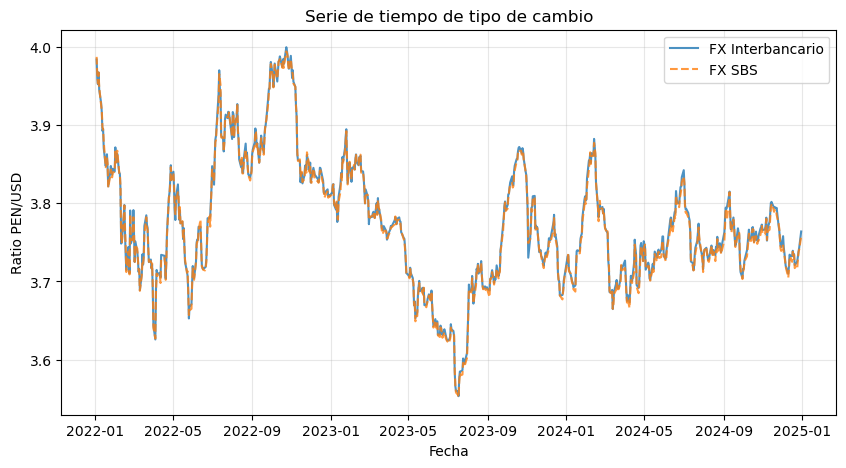

In [7]:
import matplotlib.pyplot as plt

# Graficar niveles de FX (Peru)
plt.figure(figsize=(10, 5))
plt.plot(df_wide.index, df_wide['fx_interbank'], label='FX Interbancario', alpha=0.8)
plt.plot(df_wide.index, df_wide['fx_sbs'], label='FX SBS', linestyle='--', alpha=0.8)

plt.title('Serie de tiempo de tipo de cambio')
plt.xlabel('Fecha')
plt.ylabel('Ratio PEN/USD')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

7. *(Proportions)* Compute the **share of positive-return days** by ticker (USA).  


In [8]:
# Creamos una columna booleana que es True si el retorno es > 0
df_usa_tidy['pos_ret'] = df_usa_tidy['ret'] > 0

# Calculamos el promedio de esa columna booleana por ticker
positive_shares = df_usa_tidy.groupby('ticker')['pos_ret'].mean()

print(positive_shares)

ticker
GLD    0.534236
SPY    0.547771
TLT    0.490446
Name: pos_ret, dtype: float64


8. Plot that share as a **bar chart** and add **labels above each bar** (`annotate`).  


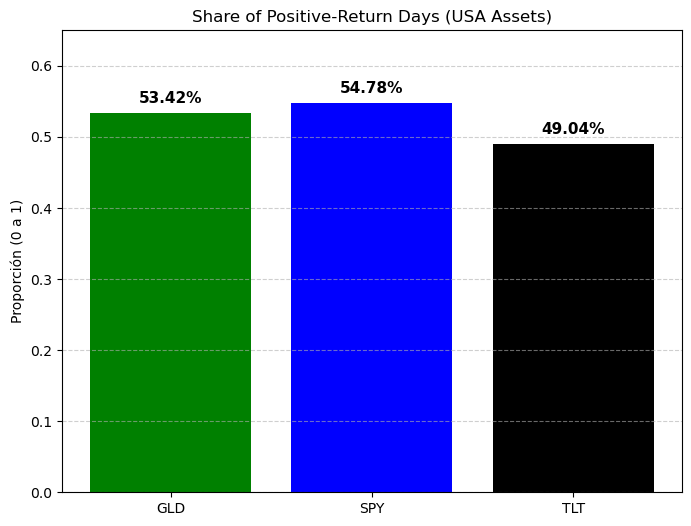

In [9]:
# Gráfico de barras con etiquetas (annotate)
plt.figure(figsize=(8, 6))
bars = plt.bar(positive_shares.index, positive_shares.values, color=['green','blue','black'])

# Añadir etiquetas arriba de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.annotate(f'{yval:.2%}', 
                 xy=(bar.get_x() + bar.get_width() / 2, yval),
                 xytext=(0, 5),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Share of Positive-Return Days (USA Assets)')
plt.ylabel('Proporción (0 a 1)')
plt.ylim(0, 0.65)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

9. *(Distributions)* Compare the distribution of **Peru Gold** vs **GLD** (histogram).  


In [10]:
bcrp_wide = df_wide.copy()
yf_data   = df_usa_tidy.copy()

In [11]:
bcrp_wide['rgold'] = np.log(bcrp_wide['gold']/bcrp_wide['gold'].shift(1))

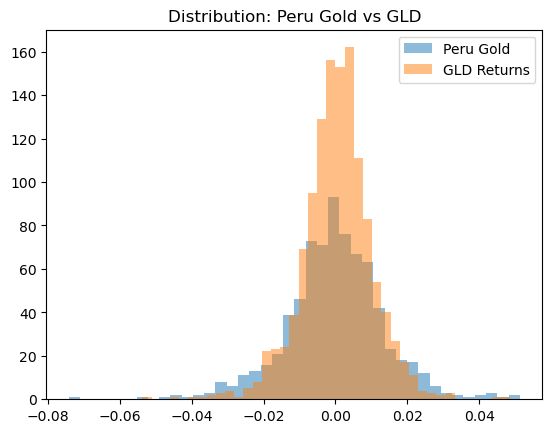

In [12]:
peru_gold = bcrp_wide["rgold"].dropna()
gld_ret = yf_data[yf_data["ticker"]=="GLD"]["ret"].dropna()

plt.hist(peru_gold, bins=40, alpha=0.5, label="Peru Gold")
plt.hist(gld_ret, bins=40, alpha=0.5, label="GLD Returns")
plt.legend()
plt.title("Distribution: Peru Gold vs GLD")
plt.show()
# Observación: Los retornos de GLD están más dispersos que los del oro en Perú, lo que indica una mayor volatilidad

10. Add an **ECDF** (if used in the notebook) and comment on what changes vs the histogram.  


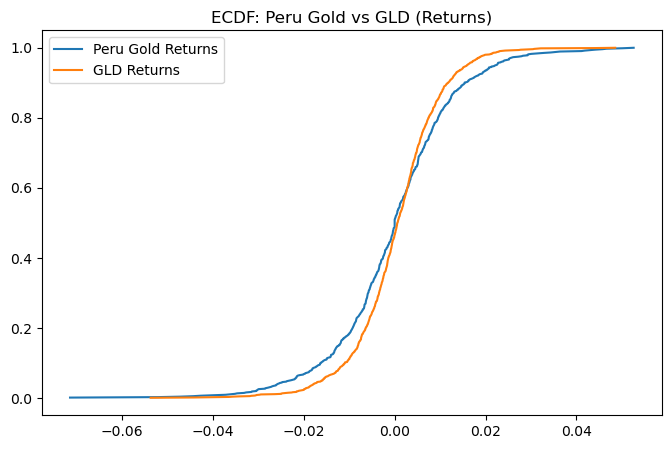

In [13]:
# Retornos del oro Perú
peru_gold_ret = bcrp_wide["gold"].pct_change().dropna()

# Retornos de GLD
gld_ret = yf_data[yf_data["ticker"]=="GLD"]["ret"].dropna()

def ecdf(x):
    x = np.sort(x)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

x_pg, y_pg = ecdf(peru_gold_ret)
x_gld, y_gld = ecdf(gld_ret)

plt.figure(figsize=(8,5))
plt.plot(x_pg, y_pg, label="Peru Gold Returns")
plt.plot(x_gld, y_gld, label="GLD Returns")
plt.legend()
plt.title("ECDF: Peru Gold vs GLD (Returns)")
plt.show()


11. *(Relationships)* Build `FX_change` and relate it to `SPY_ret` (scatter plot).  


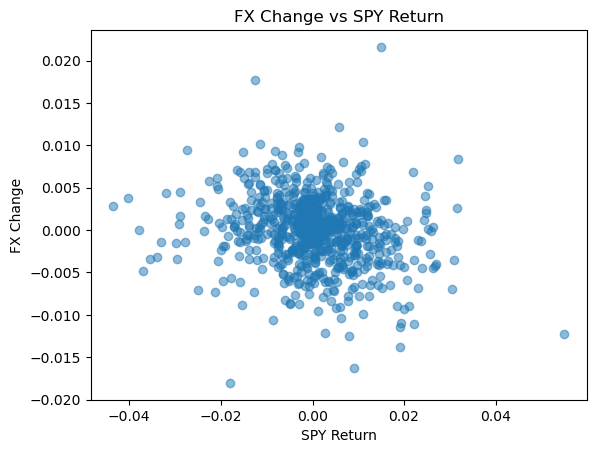

In [14]:
fx_change = bcrp_wide["fx_interbank"].pct_change()

spy_ret = (
    yf_data[yf_data["ticker"]=="SPY"]
    .set_index("date")["ret"]
)

df_rel = pd.concat([fx_change, spy_ret], axis=1).dropna()
df_rel.columns = ["FX_change", "SPY_ret"]

plt.scatter(df_rel["SPY_ret"], df_rel["FX_change"], alpha=0.5)
plt.xlabel("SPY Return")
plt.ylabel("FX Change")
plt.title("FX Change vs SPY Return")
plt.show()


12. Compute the **correlation** between `FX_change` and `SPY_ret` and explain the sign.  


In [15]:
df_rel.corr()
#La correlación negativa confirma lo observado en el gráfico

,FX_change,SPY_ret
FX_change,1.000000,-0.187261
SPY_ret,-0.187261,1.000000


13. Estimate a simple regression `FX_change ~ SPY_ret` and interpret the coefficient.  


In [16]:
from scipy.stats import linregress
reg = linregress(df_rel["SPY_ret"], df_rel["FX_change"])
reg.slope

#El coeficiente de la regresión es negativo, lo que indica que variaciones positivas en el SPY

-0.07041993898572729

14. *(Pandas)* Do a selection exercise: `.iloc` (position-based) vs conditional filtering.  


In [17]:
df_rel.iloc[:5]
df_rel[df_rel["SPY_ret"] > 0.02]
#el filtro condicional permite elegir observaciones que cumplen una condición específica, como retornos mayores a cierto valor.

,FX_change,SPY_ret
date,,
2022-01-28,0.002042,0.024835
2022-02-25,-0.011124,0.022064
2022-03-09,-0.004292,0.026811
2022-03-15,0.006830,0.021990
2022-03-16,-0.003526,0.022174
2022-04-28,0.005224,0.025259
2022-05-04,-0.006941,0.030453
2022-05-13,-0.004484,0.023908
2022-05-17,-0.005870,0.020571


15. Create missing data on purpose in one series and apply imputation (as in the notebook).  


In [18]:
df_impute = df_wide.copy()

# Creamos un hueco de 10 días en la serie de cobre (copper)
# Usamos .iloc para seleccionar una tajada de filas en la columna de copper
df_impute.iloc[20:30, df_impute.columns.get_loc('copper')] = np.nan

print(f"Valores nulos creados en 'copper': {df_impute['copper'].isna().sum()}")

# Aplicamos imputación por interpolación
df_impute['copper_fixed'] = df_impute['copper'].interpolate(method='linear')

# Verificamos que ya no hay nulos
print(f"Valores nulos después de corregir: {df_impute['copper_fixed'].isna().sum()}")

# Mostramos un fragmento donde ocurrió el cambio
print("\nComparación (filas 19 a 31):")
print(df_impute[['copper', 'copper_fixed']].iloc[18:32])

Valores nulos creados en 'copper': 10
Valores nulos después de corregir: 0

Comparación (filas 19 a 31):
series       copper  copper_fixed
date                             
2022-01-27  1806.75   1806.750000
2022-01-28  1788.15   1788.150000
2022-01-31      NaN   1795.240909
2022-02-01      NaN   1802.331818
2022-02-02      NaN   1809.422727
2022-02-03      NaN   1816.513636
2022-02-04      NaN   1823.604545
2022-02-07      NaN   1830.695455
2022-02-08      NaN   1837.786364
2022-02-09      NaN   1844.877273
2022-02-10      NaN   1851.968182
2022-02-11      NaN   1859.059091
2022-02-14  1866.15   1866.150000
2022-02-15  1848.55   1848.550000


16. Standardize a variable (z-score) and plot **before vs after**.  


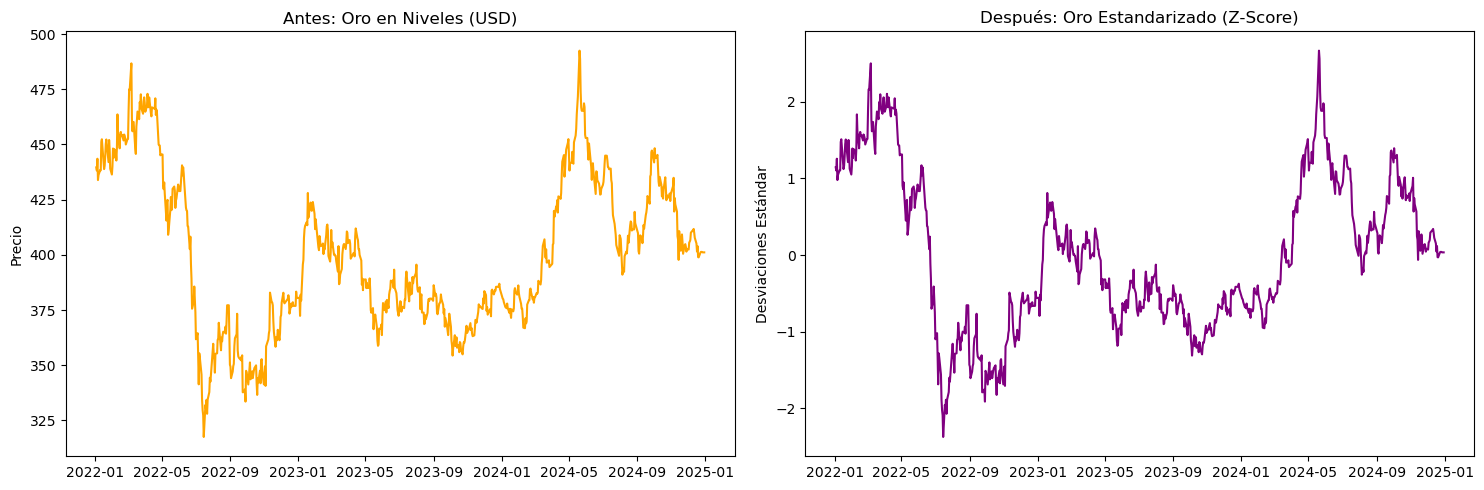

Nueva media: -0.00
Nueva desviación estándar: 1.00


In [19]:
from sklearn.preprocessing import StandardScaler

# Seleccionamos la serie de oro para el ejemplo
gold_prices = df_wide[['gold']].dropna()

# Calculamos z-score manualmente para entender la lógica: (x - media) / std
gold_mean = gold_prices['gold'].mean()
gold_std = gold_prices['gold'].std()
df_wide['gold_zscore'] = (df_wide['gold'] - gold_mean) / gold_std

# Graficar la comparación
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Antes (Precios originales en USD)
ax[0].plot(df_wide.index, df_wide['gold'], color='orange')
ax[0].set_title('Antes: Oro en Niveles (USD)')
ax[0].set_ylabel('Precio')

# Después (Z-score - sin unidades)
ax[1].plot(df_wide.index, df_wide['gold_zscore'], color='purple')
ax[1].set_title('Después: Oro Estandarizado (Z-Score)')
ax[1].set_ylabel('Desviaciones Estándar')

plt.tight_layout()
plt.show()

print(f"Nueva media: {df_wide['gold_zscore'].mean():.2f}")
print(f"Nueva desviación estándar: {df_wide['gold_zscore'].std():.2f}")

17. Find the day with the largest `|SPY_ret|` and **annotate it** in the returns plot (like the exercise).  


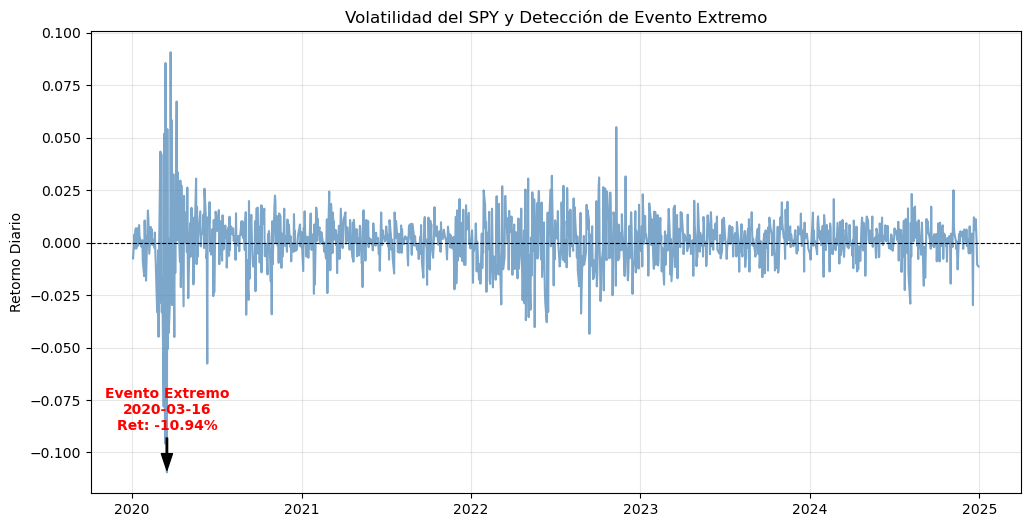

In [20]:
# Obtenemos solo los datos de SPY
df_spy = df_usa_tidy[df_usa_tidy['ticker'] == 'SPY'].copy()

# Encontrar el índice del valor absoluto máximo
idx_extreme = df_spy['ret'].abs().idxmax()
row_extreme = df_spy.loc[idx_extreme]

extreme_date = row_extreme['date']
extreme_val = row_extreme['ret']

# Graficar los retornos del SPY
plt.figure(figsize=(12, 6))
plt.plot(df_spy['date'], df_spy['ret'], label='Retornos Diarios SPY', color='steelblue', alpha=0.7)

# Añadir la anotación en el punto máximo/mínimo
plt.annotate(f'Evento Extremo\n{extreme_date.strftime("%Y-%m-%d")}\nRet: {extreme_val:.2%}', 
             xy=(extreme_date, extreme_val),
             xytext=(extreme_date, extreme_val + 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             ha='center', fontsize=10, fontweight='bold', color='red')

plt.title('Volatilidad del SPY y Detección de Evento Extremo')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylabel('Retorno Diario')
plt.grid(alpha=0.3)
plt.show()


18. Save one figure into `/figures` using `savefig` and verify the file exists.  


Imagen guardada en 'figures/spy_volatility.png'


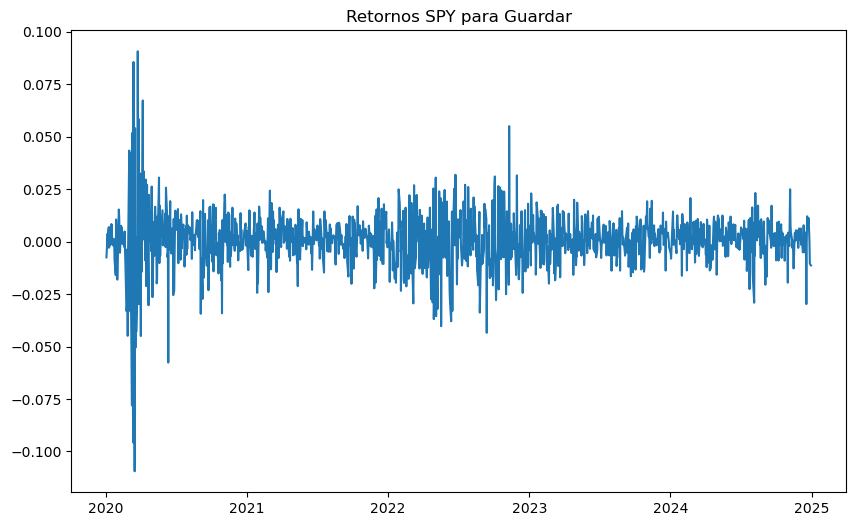

In [21]:
import os

# Crear carpeta 
if not os.path.exists('figures'):
    os.makedirs('figures')

plt.figure(figsize=(10, 6))
plt.plot(df_spy['date'], df_spy['ret'])
plt.title('Retornos SPY para Guardar')

plt.savefig('figures/spy_volatility.png')
print("Imagen guardada en 'figures/spy_volatility.png'")

19. Build a **summary stats table** for returns (mean, sd, p5, p95, etc.).  


In [22]:
# Calculamos las estadísticas agrupando por ticker
summary_stats = df_usa_tidy.groupby('ticker')['ret'].agg([
    'mean', 
    'std', 
    'min', 
    lambda x: x.quantile(0.05), # Percentil 5
    'median', 
    lambda x: x.quantile(0.95), # Percentil 95
    'max'
])

# Renombrar las columnas de los lambdas
summary_stats.columns = ['Mean', 'Std Dev', 'Min', 'P5 (VaR 95%)', 'Median', 'P95', 'Max']

print("Tabla de Estadísticas de Retornos:")
display(summary_stats)

Tabla de Estadísticas de Retornos:


,Mean,Std Dev,Min,P5 (VaR 95%),Median,P95,Max
ticker,,,,,,,
GLD,0.000457,0.009782,-0.053694,-0.015887,0.000613,0.015893,0.048530
SPY,0.000621,0.013232,-0.109424,-0.019266,0.000903,0.018003,0.090603
TLT,-0.000189,0.011320,-0.066683,-0.017265,-0.000207,0.017022,0.075195


20. Compute **historical 95% VaR** for a **60/40 portfolio (SPY/TLT)** and explain what it means.


In [23]:
# 1. Preparar datos de SPY y TLT en formato ancho
port_data = df_usa_tidy.pivot(index='date', columns='ticker', values='ret')[['SPY', 'TLT']].dropna()

# 2. Calcular retornos del portafolio (60% SPY, 40% TLT)
port_data['portfolio_ret'] = 0.60 * port_data['SPY'] + 0.40 * port_data['TLT']

# 3. Calcular el VaR Histórico al 95% (es el percentil 5 de los retornos)
var_95 = port_data['portfolio_ret'].quantile(0.05)

print(f"Historical 95% VaR del portafolio 60/40: {var_95:.2%}")

# Explicación
print(f"\nExplicación: Existe un 5% de probabilidad de que el portafolio pierda "
      f"más del {abs(var_95):.2%} en un solo día, basado en datos históricos.")

Historical 95% VaR del portafolio 60/40: -1.34%

Explicación: Existe un 5% de probabilidad de que el portafolio pierda más del 1.34% en un solo día, basado en datos históricos.
